In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# ==========================================
# 1. ส่วนประกอบ: Encoder (ทีมบีบอัด)
# ==========================================
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        # Input: 3 x 32 x 32
        
        # Layer 1: ลดขนาดภาพเหลือครึ่งหนึ่ง (Stride=2)
        # 32x32 -> 16x16, Channels: 3 -> 12
        self.conv1 = nn.Conv2d(3, 12, kernel_size=4, stride=2, padding=1)
        
        # Layer 2: ลดขนาดภาพเหลือครึ่งหนึ่ง
        # 16x16 -> 8x8, Channels: 12 -> 24
        self.conv2 = nn.Conv2d(12, 24, kernel_size=4, stride=2, padding=1)
        
        # Layer 3: ลดขนาดภาพเหลือครึ่งหนึ่ง (Latent Space)
        # 8x8 -> 4x4, Channels: 24 -> 48
        self.conv3 = nn.Conv2d(24, 48, kernel_size=4, stride=2, padding=1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        return x # Compressed Representation (Latent Vector)

In [3]:
# ==========================================
# 2. ส่วนประกอบ: Decoder (ทีมขยายกลับ)
# ==========================================
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        
        # ใช้ ConvTranspose2d (Deconvolution) เพื่อขยายภาพ
        
        # Layer 1: ขยายจาก 4x4 -> 8x8
        self.t_conv1 = nn.ConvTranspose2d(48, 24, kernel_size=4, stride=2, padding=1)
        
        # Layer 2: ขยายจาก 8x8 -> 16x16
        self.t_conv2 = nn.ConvTranspose2d(24, 12, kernel_size=4, stride=2, padding=1)
        
        # Layer 3: ขยายจาก 16x16 -> 32x32 (กลับสู่ขนาดเดิม)
        self.t_conv3 = nn.ConvTranspose2d(12, 3, kernel_size=4, stride=2, padding=1)

    def forward(self, x):
        x = F.relu(self.t_conv1(x))
        x = F.relu(self.t_conv2(x))
        # ใช้ Tanh เพราะ input เรา Normalize ไว้ที่ช่วง [-1, 1]
        x = torch.tanh(self.t_conv3(x)) 
        return x

In [4]:
# ==========================================
# 3. ประกอบร่าง: Convolutional Autoencoder
# ==========================================
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        latent = self.encoder(x)
        reconstructed = self.decoder(latent)
        return reconstructed

In [5]:
# ==========================================
# 4. การเตรียมข้อมูล (CIFAR-10)
# ==========================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Hyperparameters
batch_size = 64
learning_rate = 0.001
epochs = 10 # จำนวนรอบฝึก

# Normalize เป็น [-1, 1] เพื่อให้แมตช์กับ Tanh ของ Decoder
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=0)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=0)

Using device: cuda


In [6]:
# ==========================================
# 5. Training Loop (Unsupervised Learning)
# ==========================================
model = ConvAutoencoder().to(device)
criterion = nn.MSELoss() # วัดความต่างระหว่าง "ภาพเดิม" กับ "ภาพใหม่"
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_losses = []
test_losses = []

print("Start Training Autoencoder...")

for epoch in range(epochs):
    
    # --- Training Phase ---
    model.train()
    running_loss = 0.0
    
    for data in trainloader:
        img, _ = data # ไม่ใช้ Labels เพราะ Autoencoder เรียนรู้จากตัวเอง
        img = img.to(device)
        
        optimizer.zero_grad()
        outputs = model(img)
        
        # Loss: เทียบ Output กับ Input (ไม่ใช่ Label)
        loss = criterion(outputs, img) 
        
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_train_loss = running_loss / len(trainloader)
    train_losses.append(avg_train_loss)

    # --- Evaluation Phase ---
    model.eval()
    running_test_loss = 0.0
    
    with torch.no_grad():
        for data in testloader:
            img, _ = data
            img = img.to(device)
            outputs = model(img)
            loss = criterion(outputs, img)
            running_test_loss += loss.item()
    
    avg_test_loss = running_test_loss / len(testloader)
    test_losses.append(avg_test_loss)
    
    print(f'Epoch [{epoch+1}/{epochs}] Train Loss: {avg_train_loss:.6f} | Test Loss: {avg_test_loss:.6f}')

print('Finished Training')

Start Training Autoencoder...
Epoch [1/10] Train Loss: 0.049112 | Test Loss: 0.023798
Epoch [2/10] Train Loss: 0.019510 | Test Loss: 0.016500
Epoch [3/10] Train Loss: 0.015053 | Test Loss: 0.013739
Epoch [4/10] Train Loss: 0.013290 | Test Loss: 0.012602
Epoch [5/10] Train Loss: 0.012169 | Test Loss: 0.011456
Epoch [6/10] Train Loss: 0.011144 | Test Loss: 0.010496
Epoch [7/10] Train Loss: 0.010448 | Test Loss: 0.010275
Epoch [8/10] Train Loss: 0.009903 | Test Loss: 0.009669
Epoch [9/10] Train Loss: 0.009409 | Test Loss: 0.009273
Epoch [10/10] Train Loss: 0.008797 | Test Loss: 0.008283
Finished Training


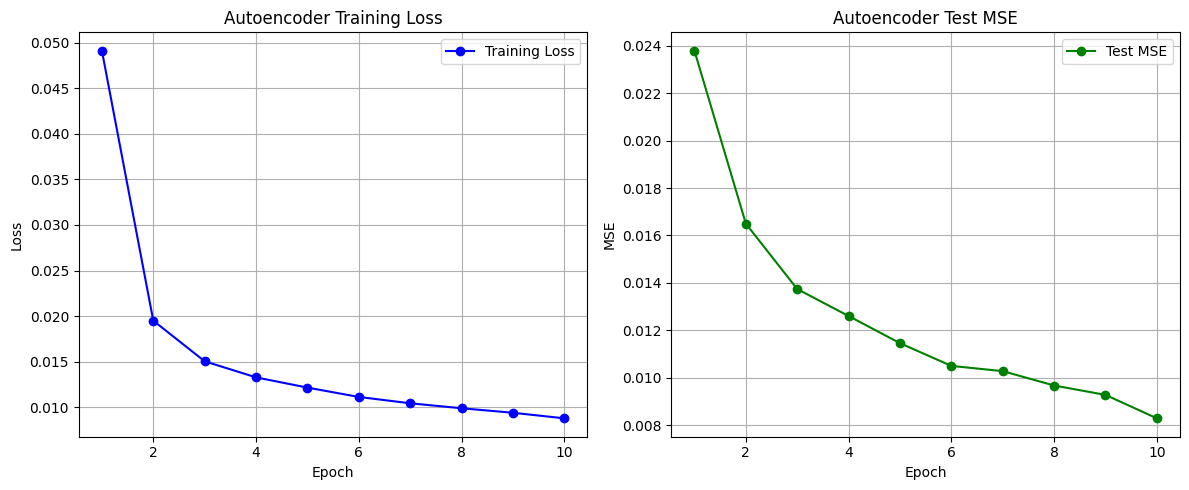

In [12]:
# ==========================================
# 6. Plot Graph
# ==========================================
epochs_range = range(1, epochs + 1)

plt.figure(figsize=(12, 5))

# Plot 1: Training Loss
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, 'b-o', label='Training Loss')
plt.title('Autoencoder Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

# Plot 2: Test MSE (ใน Autoencoder Loss ปกติคือ MSE อยู่แล้ว)
plt.subplot(1, 2, 2)
plt.plot(epochs_range, test_losses, 'g-o', label='Test MSE')
plt.title('Autoencoder Test MSE')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

# ==========================================
# (แถม) ส่วนแสดงรูปภาพแยกต่างหาก ถ้าอยากดูผลลัพธ์
# ==========================================
def imshow(img, title):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.cpu().numpy()
    plt.figure(figsize=(8, 4))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title)
    plt.axis('off')
    plt.show()

# ดึงภาพมาโชว์สัก 1 Batch
dataiter = iter(testloader)
images, _ = next(dataiter)
images = images.to(device)

with torch.no_grad():
    output_images = model(images)
